In [38]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from neurite_outgrowth import Neuron, NeuriteOutgrowth 

## Dendritic overshoot

#### Create neurons

In [39]:
neuron_ls = [Neuron((0.5,0.5), radius=0.5), 
             Neuron((0.5,-0.5), radius=0.5), 
             Neuron((-0.5,-0.5), radius=0.5),
             Neuron((-0.5,0.5), radius=0.5),
             Neuron((0,0), radius=0.5)
            ]

In [40]:
neuron_ls

[Neuron(
  pos=(0.5, 0.5), radius=0.5,
  valence=1, potential=0.0,
  theta=0.5, alpha=0.1,
  rho=0.0001, epsilon=0.6, beta=0.1 
 ), Neuron(
  pos=(0.5, -0.5), radius=0.5,
  valence=1, potential=0.0,
  theta=0.5, alpha=0.1,
  rho=0.0001, epsilon=0.6, beta=0.1 
 ), Neuron(
  pos=(-0.5, -0.5), radius=0.5,
  valence=1, potential=0.0,
  theta=0.5, alpha=0.1,
  rho=0.0001, epsilon=0.6, beta=0.1 
 ), Neuron(
  pos=(-0.5, 0.5), radius=0.5,
  valence=1, potential=0.0,
  theta=0.5, alpha=0.1,
  rho=0.0001, epsilon=0.6, beta=0.1 
 ), Neuron(
  pos=(0, 0), radius=0.5,
  valence=1, potential=0.0,
  theta=0.5, alpha=0.1,
  rho=0.0001, epsilon=0.6, beta=0.1 
 )]

#### Populate neural ensemble

In [41]:
overshoot_sys = NeuriteOutgrowth(neuron_ls)

In [42]:
overshoot_sys._overlap()

array([[0.78539816, 0.        , 0.        , 0.        , 0.14269908],
       [0.        , 0.78539816, 0.        , 0.        , 0.14269908],
       [0.        , 0.        , 0.78539816, 0.        , 0.14269908],
       [0.        , 0.        , 0.        , 0.78539816, 0.14269908],
       [0.14269908, 0.14269908, 0.14269908, 0.14269908, 0.78539816]])

#### Simulate dynamics of neurite outgrowth/retraction

In [43]:
# init_state = [n.potential for n in nsys.neuron_ls] + [n.radius for n in nsys.neuron_ls]
# out_dc = nsys.OutgrowthSys(t, init_state)
t = np.arange(0, 15000)
out_dc = overshoot_sys.OutgrowthSys(t)

#### Organize data and plot

In [128]:
state_wd_df = pd.DataFrame.from_dict(out_dc)

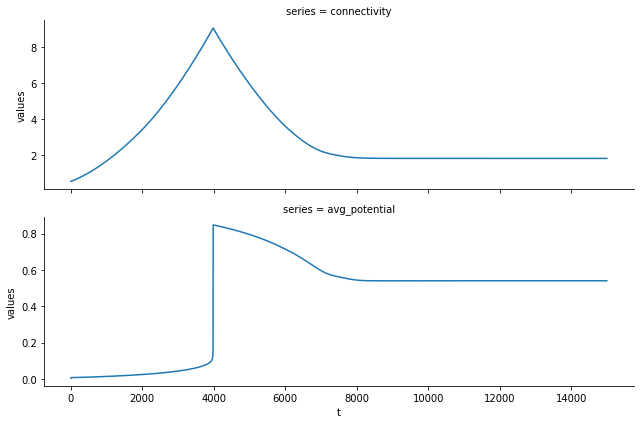

In [45]:
_=(
    state_wd_df
    .loc[lambda df: df.t.gt(0),['t', 'connectivity', 'avg_potential']]
    .melt(id_vars='t', var_name='series', value_name='values')
    .pipe(sns.FacetGrid, row='series', aspect=3, sharey=False)
    .map(sns.lineplot, 't', 'values')
)

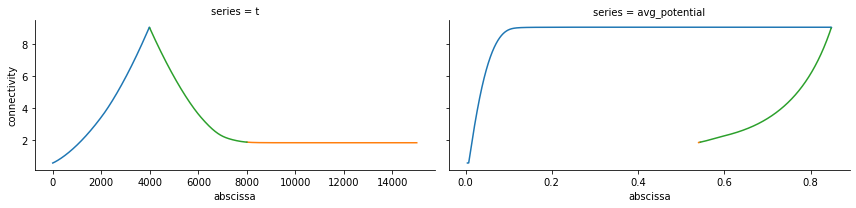

In [46]:
_=(
    state_wd_df
    .loc[lambda df: df.t.gt(0),['t', 'connectivity', 'avg_potential']]
    .assign(branch = lambda df: np.where(df.t<4000, 0, np.where(df.t>8000, 1, 2)))
    .melt(id_vars=['connectivity', 'branch'], var_name='series', value_name='abscissa')
    .pipe(sns.FacetGrid, col='series', hue='branch', aspect=2, sharex=False, sharey=True)
    .map(sns.lineplot, 'abscissa', 'connectivity')
)

In [47]:
state_df = (
    state_wd_df.loc[:,[c for c in state_wd_df.columns if c not in ['connectivity', 'avg_potential']]]
    .pipe(pd.wide_to_long, stubnames=['potential', 'radius'], i='t', j='neuron idx', sep='_')
    .reset_index()
    .melt(id_vars=['t', 'neuron idx'], var_name='series', value_name='value')
)

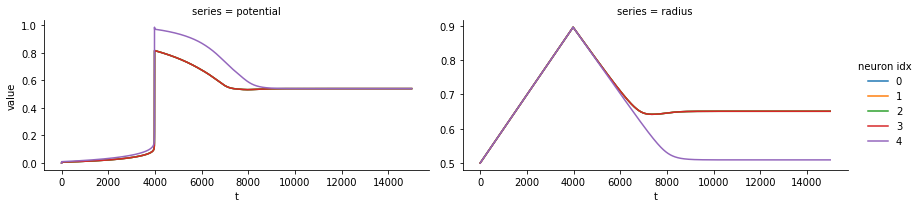

In [48]:
outgrowth_sim_pl=(
    state_df
    .pipe(sns.FacetGrid, col='series', hue='neuron idx', aspect=2, sharey=False)
    .map(sns.lineplot, 't', 'value')
)
_=outgrowth_sim_pl.add_legend()

## Run-away connectivity

In [80]:
mix_neuron_ls = [Neuron((0.5,0.5), radius=0.5), 
             Neuron((0.5,-0.5), radius=0.5), 
             Neuron((-0.5,-0.5), radius=0.5),
             Neuron((-0.5,0.5), radius=0.5),
             Neuron((0,0), radius=0.5, valence=False)
            ]

In [82]:
runawaysys = NeuriteOutgrowth(mix_neuron_ls)

In [83]:
t = np.arange(0, 25000)
runaway_dc = runawaysys.OutgrowthSys(t)

In [127]:
state2_wd_df = pd.DataFrame.from_dict(runaway_dc)

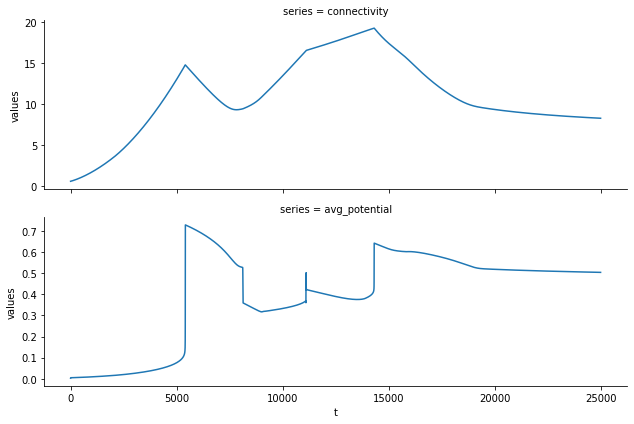

In [85]:
_=(
    state2_wd_df
    .loc[lambda df: df.t.gt(0),['t', 'connectivity', 'avg_potential']]
    .melt(id_vars='t', var_name='series', value_name='values')
    .pipe(sns.FacetGrid, row='series', aspect=3, sharey=False)
    .map(sns.lineplot, 't', 'values')
)

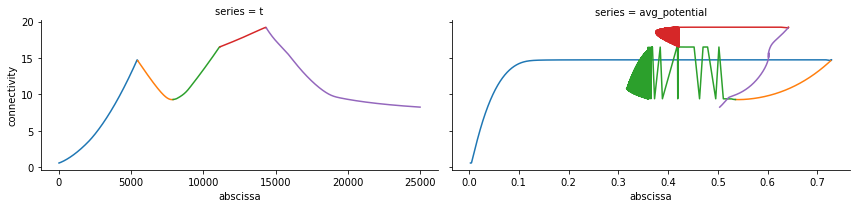

In [86]:
_=(
    state2_wd_df
    .loc[lambda df: df.t.gt(0),['t', 'connectivity', 'avg_potential']]
    .assign(branch = lambda df: 
            np.where(df.t.le(5450), 0, 
                     np.where(df.t.le(7900), 1, 
                              np.where(df.t.le(11150), 2, 
                                       np.where(df.t.le(14350), 3, 4)))))
    .melt(id_vars=['connectivity', 'branch'], var_name='series', value_name='abscissa')
    .pipe(sns.FacetGrid, col='series', hue='branch', aspect=2, sharex=False, sharey=True)
    .map(sns.lineplot, 'abscissa', 'connectivity')
)

In [87]:
state2_df = (
    state2_wd_df.loc[:,[c for c in state2_wd_df.columns if c not in ['connectivity', 'avg_potential']]]
    .pipe(pd.wide_to_long, stubnames=['potential', 'radius'], i='t', j='neuron idx', sep='_')
    .reset_index()
    .melt(id_vars=['t', 'neuron idx'], var_name='series', value_name='value')
)

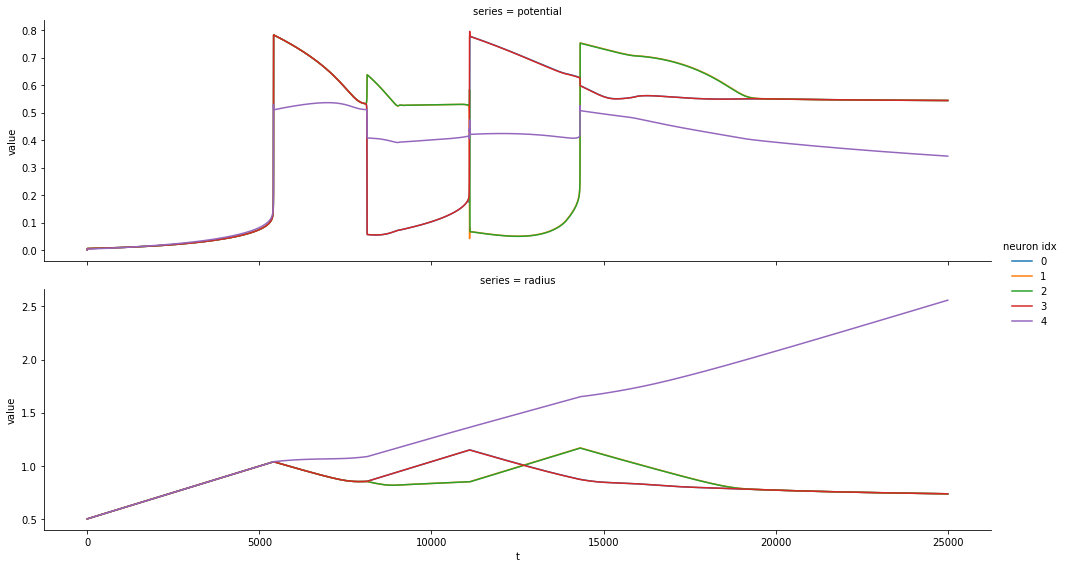

In [88]:
outgrowth_sim_pl=(
    state2_df
    .pipe(sns.FacetGrid, row='series', hue='neuron idx', height=4, aspect=3.5, sharey=False)
    .map(sns.lineplot, 't', 'value')
)
_=outgrowth_sim_pl.add_legend()

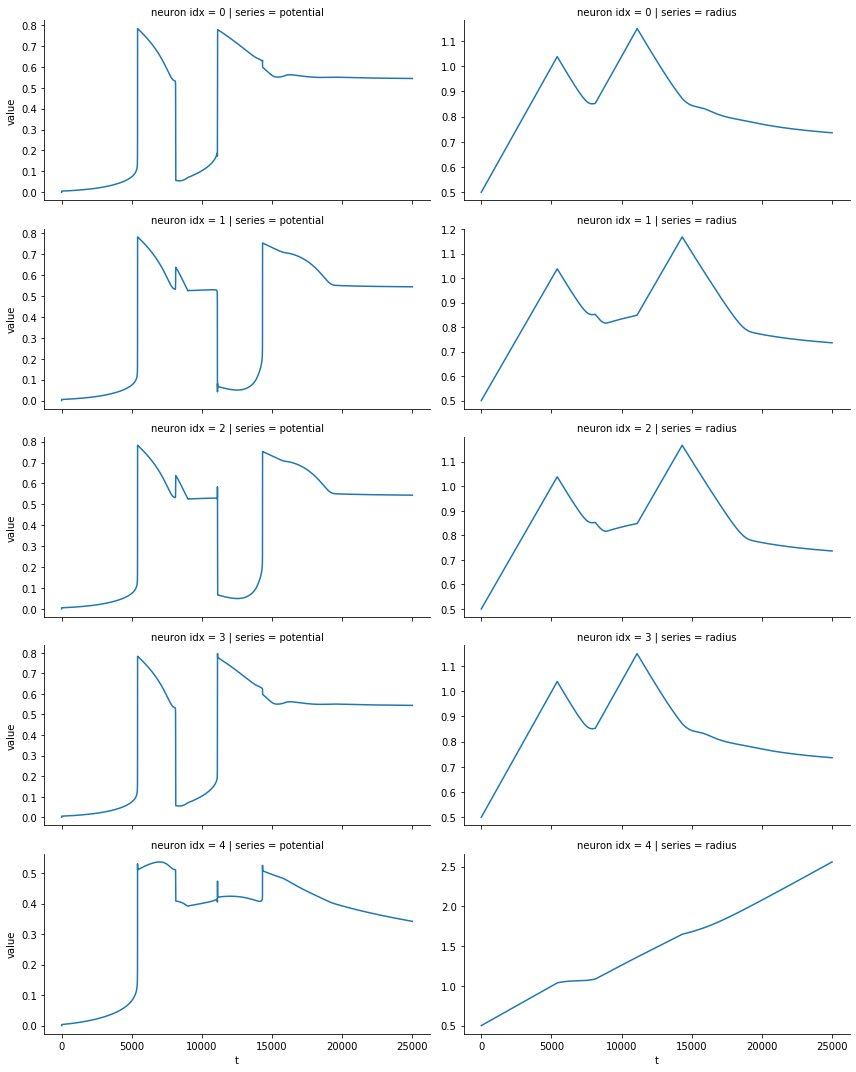

In [89]:
_=(
    state2_df
    .pipe(sns.FacetGrid, row='neuron idx', col='series', aspect=2, sharey=False)
    .map(sns.lineplot, 't', 'value')
)

## Oscillations

In [102]:
osc_neuron_ls = [Neuron((0.5,0.5), radius=0.5, epsilon=0.5), 
             Neuron((0.5,-0.5), radius=0.5, epsilon=0.6), 
             Neuron((-0.5,-0.5), radius=0.5, epsilon=0.7),
             Neuron((-0.5,0.5), radius=0.5, epsilon=0.8),
             Neuron((0,0), radius=0.5, epsilon=0.4)
            ]

In [103]:
osc_sys = NeuriteOutgrowth(osc_neuron_ls)

In [104]:
t = np.arange(0, 25000)
osc_dc = osc_sys.OutgrowthSys(t)

In [126]:
state3_wd_df = pd.DataFrame.from_dict(osc_dc)

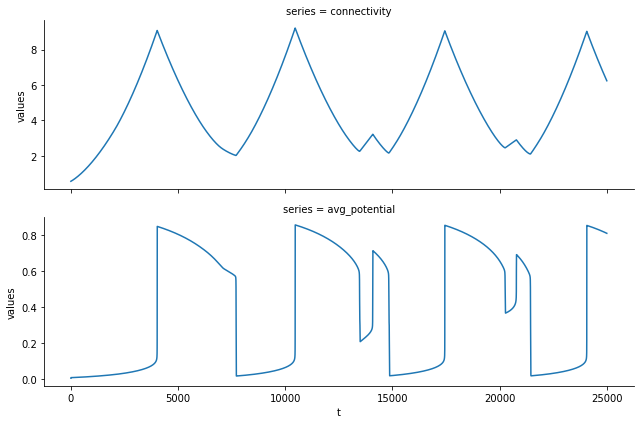

In [106]:
_=(
    state3_wd_df
    .loc[lambda df: df.t.gt(0),['t', 'connectivity', 'avg_potential']]
    .melt(id_vars='t', var_name='series', value_name='values')
    .pipe(sns.FacetGrid, row='series', aspect=3, sharey=False)
    .map(sns.lineplot, 't', 'values')
)

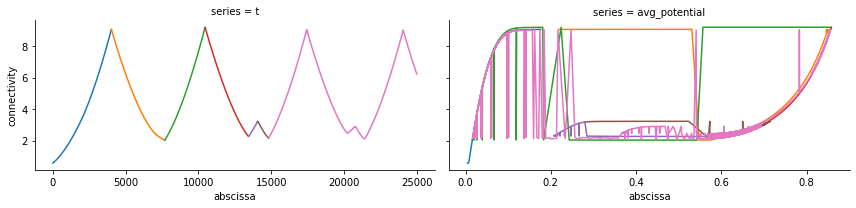

In [121]:
_=(
    state3_wd_df
    .loc[lambda df: df.t.gt(0),['t', 'connectivity', 'avg_potential']]
    .assign(branch = lambda df: 
            np.where(df.t.le(4025), 0, 
                     np.where(df.t.le(7700), 1, 
                              np.where(df.t.le(10475), 2, 
                                       np.where(df.t.le(13425), 3, 
                                                np.where(df.t.le(14050), 4, 
                                                        np.where(df.t.le(14825), 5, 6)))))))
    .melt(id_vars=['connectivity', 'branch'], var_name='series', value_name='abscissa')
    .pipe(sns.FacetGrid, col='series', hue='branch', aspect=2, sharex=False, sharey=True)
    .map(sns.lineplot, 'abscissa', 'connectivity')
)

In [122]:
state3_df = (
    state3_wd_df.loc[:,[c for c in state3_wd_df.columns if c not in ['connectivity', 'avg_potential']]]
    .pipe(pd.wide_to_long, stubnames=['potential', 'radius'], i='t', j='neuron idx', sep='_')
    .reset_index()
    .melt(id_vars=['t', 'neuron idx'], var_name='series', value_name='value')
)

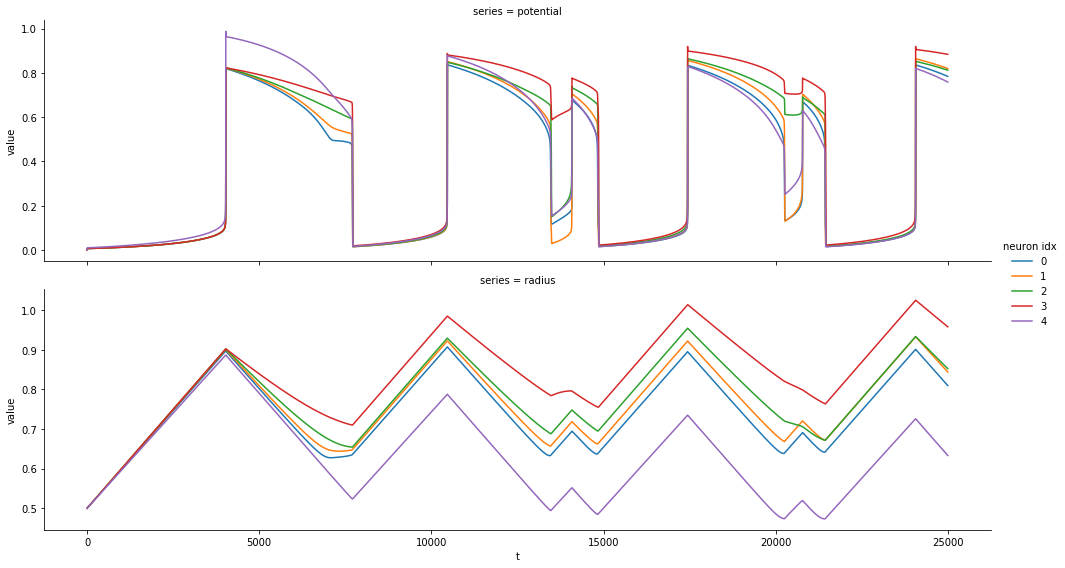

In [123]:
outgrowth_sim_pl=(
    state3_df
    .pipe(sns.FacetGrid, row='series', hue='neuron idx', height=4, aspect=3.5, sharey=False)
    .map(sns.lineplot, 't', 'value')
)
_=outgrowth_sim_pl.add_legend()

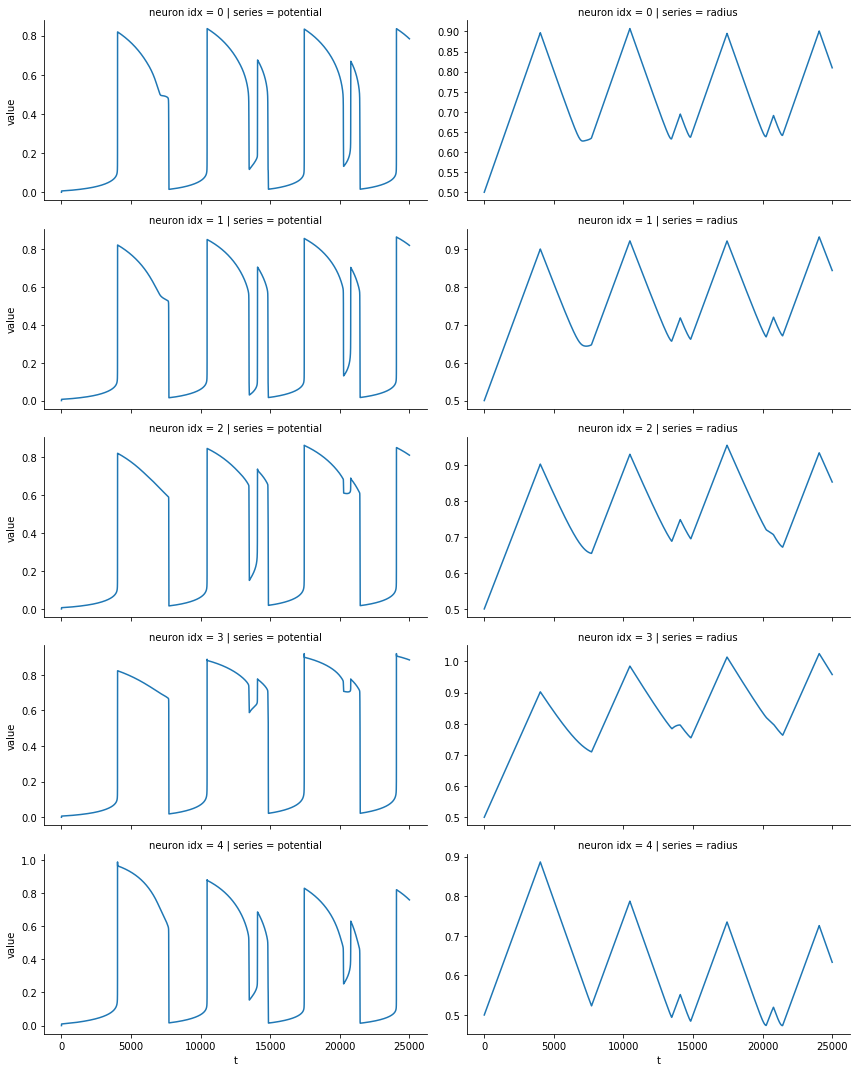

In [124]:
_=(
    state3_df
    .pipe(sns.FacetGrid, row='neuron idx', col='series', aspect=2, sharey=False)
    .map(sns.lineplot, 't', 'value')
)